In [ ]:
# Data is in DATA_OCT\dr_test_1190_NV.jpg
# Mask data for evaluation is in Boom's ILM\dr_test_1190_NV_ILM.png

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pywt
from sklearn.metrics import f1_score

def preprocess_image(image_path, img_size=(640, 640)):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise FileNotFoundError(f"Image at path {image_path} not found.")

    # Replace all white pixels (value > 250) with black
    image[image > 250] = 0

    # Detect and remove white borders
    _, thresh = cv2.threshold(image, 240, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Find all non-white pixels and get their coordinates
    non_white_pixels = np.where(thresh < 240)

    if non_white_pixels[0].size == 0 or non_white_pixels[1].size == 0:
        raise ValueError("No relevant pixels found in the image.")

    # Get the smallest and largest x and y coordinates and use them to create the bounding box
    y_min, y_max = np.min(non_white_pixels[0]), np.max(non_white_pixels[0])
    x_min, x_max = np.min(non_white_pixels[1]), np.max(non_white_pixels[1])

    # Crop the image to the bounding box of all non-white pixels
    image = image[y_min:y_max+1, x_min:x_max+1]

    # Noise reduction using median blur, bilateral filter, and non-local means denoising
    image_median = cv2.medianBlur(image, 5)
    image_bilateral = cv2.bilateralFilter(image_median, 9, 75, 75)
    image_denoised = cv2.fastNlMeansDenoising(image_bilateral, h=30)

    # Wavelet denoising
    coeffs = pywt.wavedec2(image_denoised, 'db1', level=2)
    coeffs[1:] = [tuple(pywt.threshold(i, value=10, mode='soft') for i in level) for level in coeffs[1:]]
    image_wavelet_denoised = pywt.waverec2(coeffs, 'db1')

    # Resize the denoised image
    image_resized = cv2.resize(image_wavelet_denoised, img_size)
    image_resized = np.expand_dims(image_resized, axis=-1)
    image_resized = np.expand_dims(image_resized, axis=0)
    image_resized = image_resized.astype('float32') / 255.0

    return image, image_resized

def binary_mask(image):
    # Convert the processed image to uint8
    image_uint8 = (image * 255).astype(np.uint8).squeeze()

    blurred_image = cv2.GaussianBlur(image_uint8, (5, 5), 0)
    
    # Apply binary thresholding
    # _, binary_image = cv2.threshold(image_uint8, 62.5, 255,cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    _, binary_image = cv2.threshold(blurred_image, 62.5, 255,cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    return binary_image

def canny_edge_detection(image):
    edges = cv2.Canny(image, 100, 200)
    return edges

def extract_highest_y(edges):
    height, width = edges.shape
    highest_y_values = np.full(width, height)  # Initialize with maximum Y values (bottom of image)

    for x in range(width):
        column = edges[:, x]
        y_indices = np.where(column > 0)[0]
        if y_indices.size > 0:
            highest_y = y_indices.min()  # Get the highest (minimum) Y value
            highest_y_values[x] = highest_y  # Store the highest Y value

    return highest_y_values

def plot_highest_y_on_edges(edges, highest_y_values):
    height, width = edges.shape
    output_image = np.zeros_like(edges)

    for x, y in enumerate(highest_y_values):
        if y < height:  # Ensure we don't plot outside the image
            output_image[y, x] = 255  # Plot highest Y values in white

    return output_image

def extract_top_line(highest_y_values):
    # Create an image with the top line plotted
    height = np.max(highest_y_values) + 1  # Ensure the image height is sufficient
    width = len(highest_y_values)
    top_line_image = np.zeros((height, width), dtype=np.uint8)

    # Draw the top line, making it bold
    for x, y in enumerate(highest_y_values):
        if y < height:  # Ensure we don't plot outside the image
            cv2.line(top_line_image, (x, y), (x, y + 2), 255, 2)  # Plot bold line in white

    return top_line_image

def concatenate_paths(base_path, filenames):
    return [os.path.join(base_path, filename) for filename in filenames]

def process_and_visualize_images(image_paths):
    for image_path in image_paths:
        # Preprocess the image
        original_image, preprocessed_image = preprocess_image(image_path)

        # Apply binary masking
        binary_image = binary_mask(preprocessed_image)

        # Apply Canny edge detection
        edges = canny_edge_detection(binary_image)

        # Extract highest Y value edges
        highest_y_values = extract_highest_y(edges)

        # Plot highest Y values on the edges image
        highest_y_image = plot_highest_y_on_edges(edges, highest_y_values)

        # Extract and plot only the top line
        top_line_image = extract_top_line(highest_y_values)

        # Visualize the results
        plt.figure(figsize=(25, 5))
        plt.subplot(1, 5, 1)
        plt.imshow(original_image, cmap='gray')
        plt.title('Original Image')

        plt.subplot(1, 5, 2)
        plt.imshow(binary_image, cmap='gray')
        plt.title('Binary Mask')

        plt.subplot(1, 5, 3)
        plt.imshow(edges, cmap='gray')
        plt.title('Canny Edges')

        plt.subplot(1, 5, 4)
        plt.imshow(highest_y_image, cmap='gray')
        plt.title('Highest Y Values')

        plt.subplot(1, 5, 5)
        plt.imshow(top_line_image, cmap='gray')
        plt.title('Top Line')

        plt.show()

# Example usage
test_base_path = 'DATA_OCT'
eval_base_path = 'BOOM_ILM'

# Lists of filenames for test and evaluation datasets
image_paths = ['dr_test_1190_NV.jpg', 'img_02.jpeg', 'img_04.jpeg',
    'img_05.jpeg', 'img_06.jpeg', 'img_07.jpeg',
    'img_08.jpeg', 'img_09 (1).jpeg', 'img_10.jpeg',
    'img_11.jpeg', 'img_15.jpeg', 'img_16.jpeg', 'img_17.jpeg',
    'img_18.jpeg', 'img_19.jpeg', 'img_21.jpeg',
    'img_23.jpeg', 'img_24.jpeg', 'img_25.jpeg']

eval_filenames = ['dr_test_1190_NV.jpg', 'img_02.jpeg', 'img_04.jpeg',
    'img_05.jpeg', 'img_06.jpeg', 'img_07.jpeg',
    'img_08.jpeg', 'img_09 (1).jpeg', 'img_10.jpeg',
    'img_11.jpeg', 'img_15.jpeg', 'img_16.jpeg', 'img_17.jpeg',
    'img_18.jpeg', 'img_19.jpeg', 'img_21.jpeg',
    'img_23.jpeg', 'img_24.jpeg', 'img_25.jpeg']

test_image_paths = concatenate_paths(test_base_path, image_paths)
eval_image_paths = concatenate_paths(eval_base_path, eval_filenames)

# Combine and process both test and evaluation image paths
process_and_visualize_images(test_image_paths)


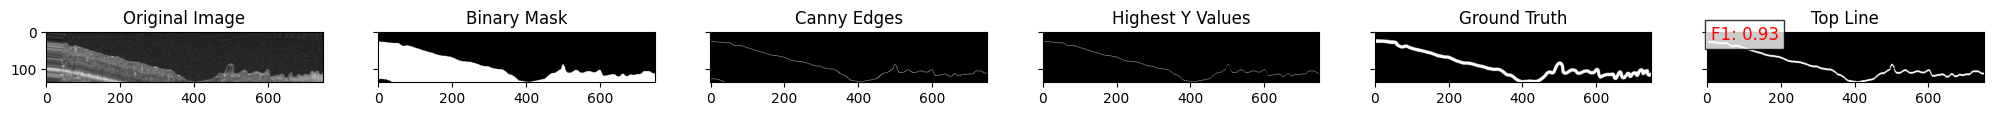

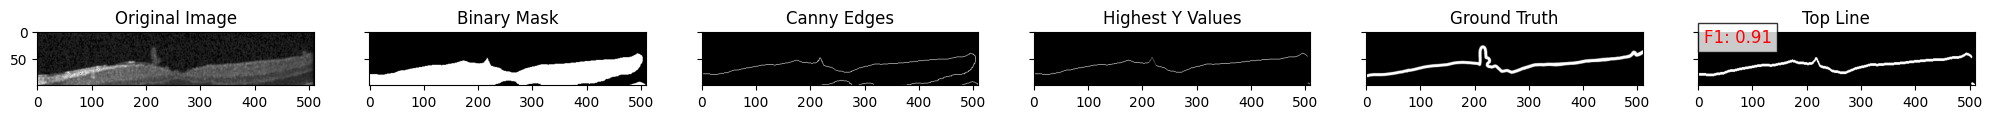

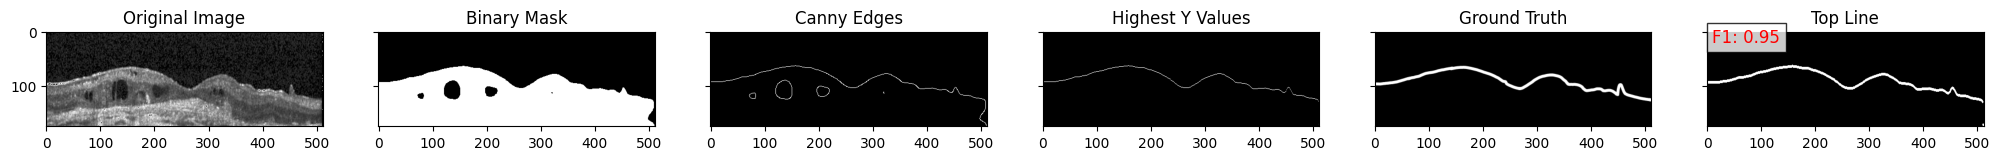

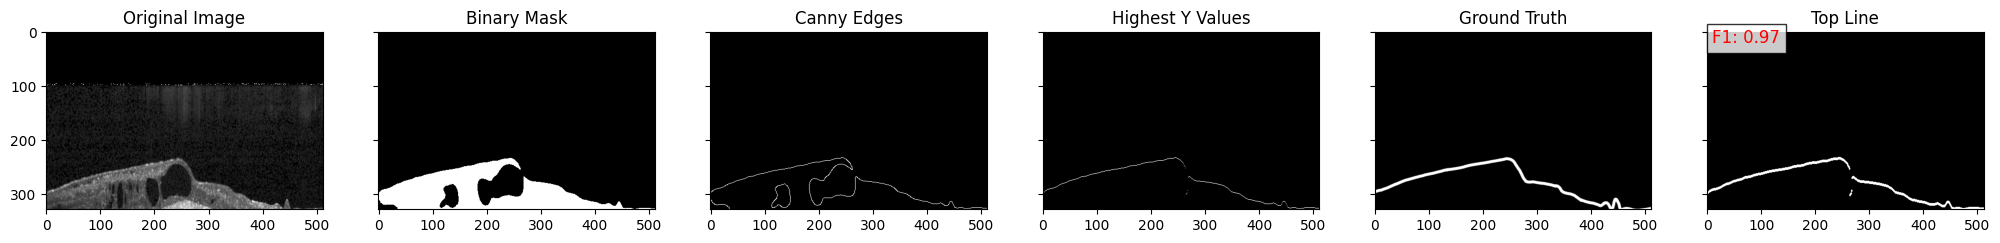

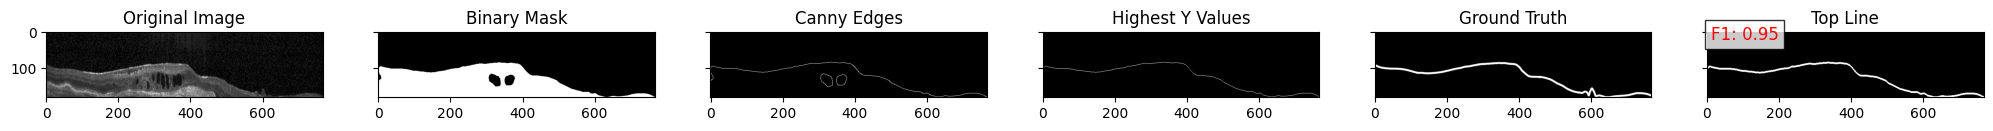

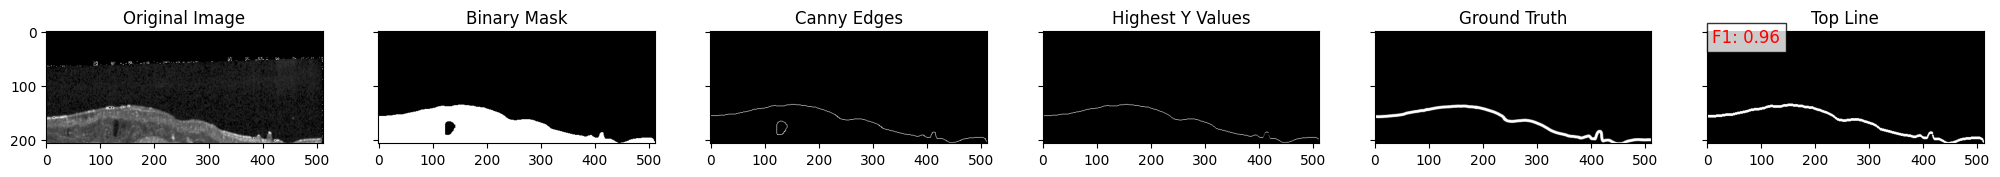

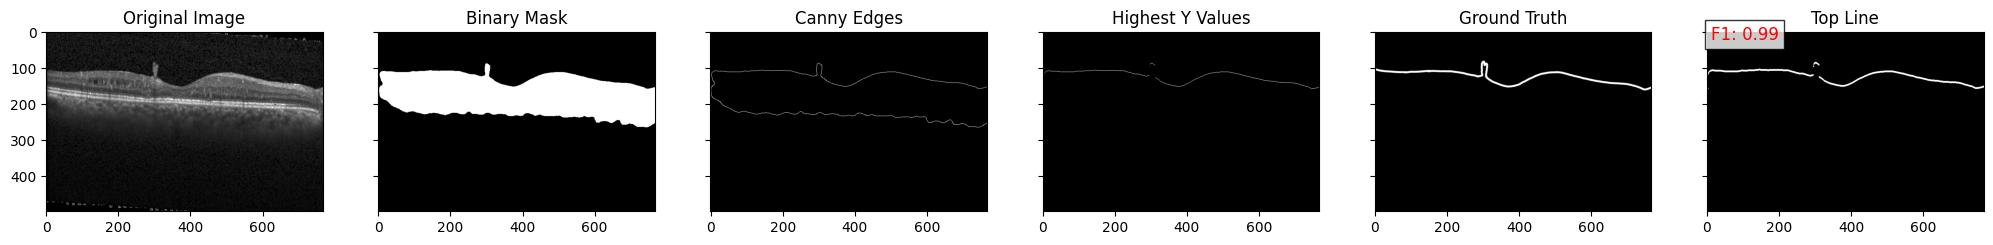

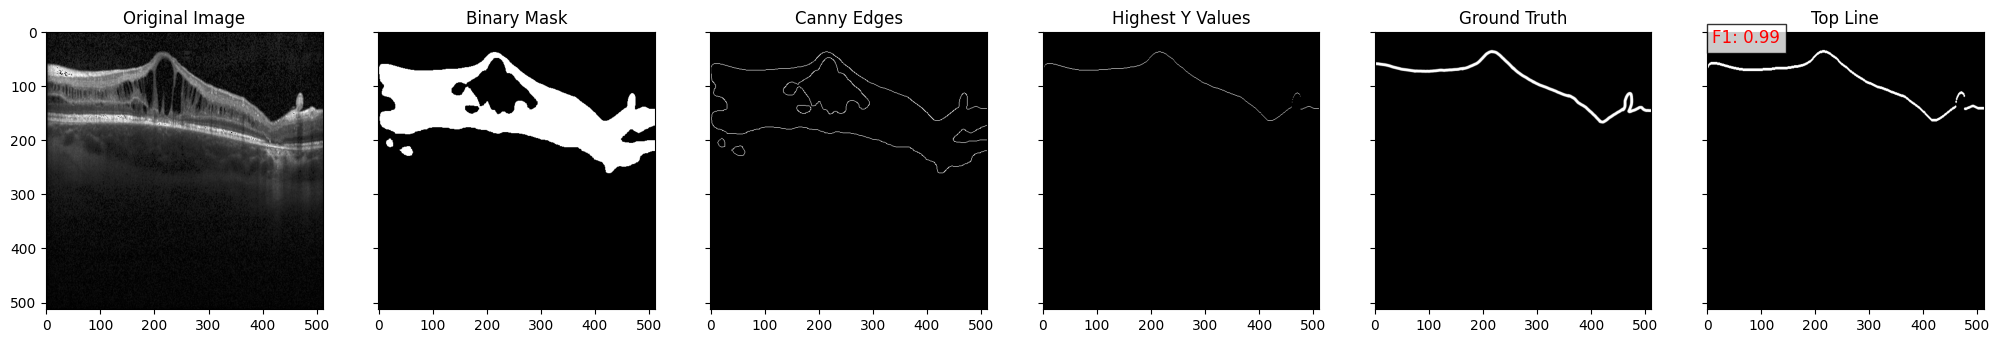

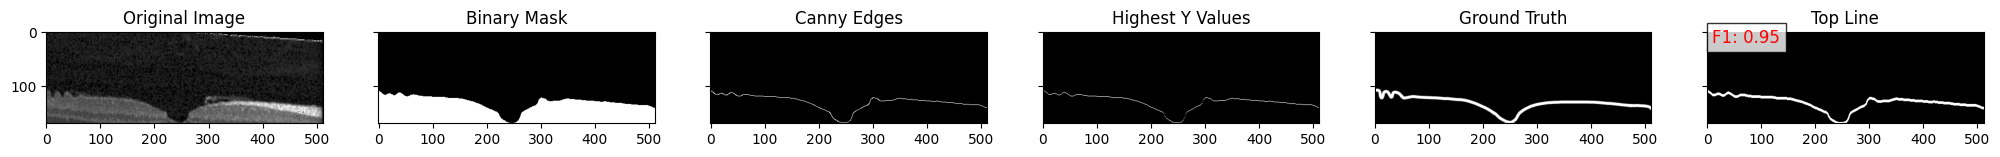

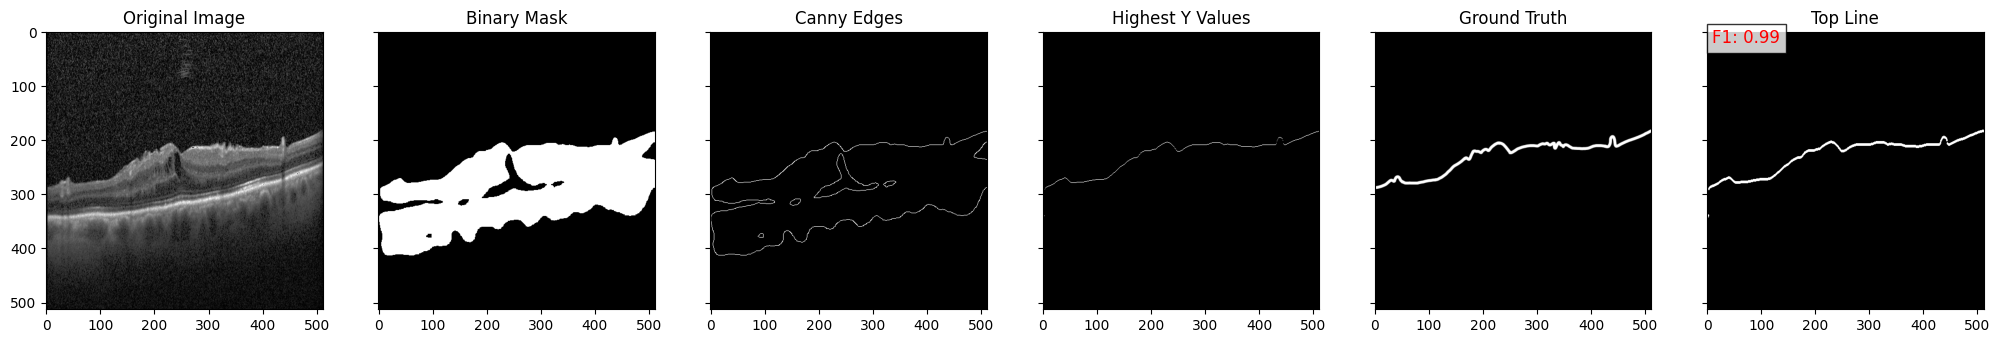

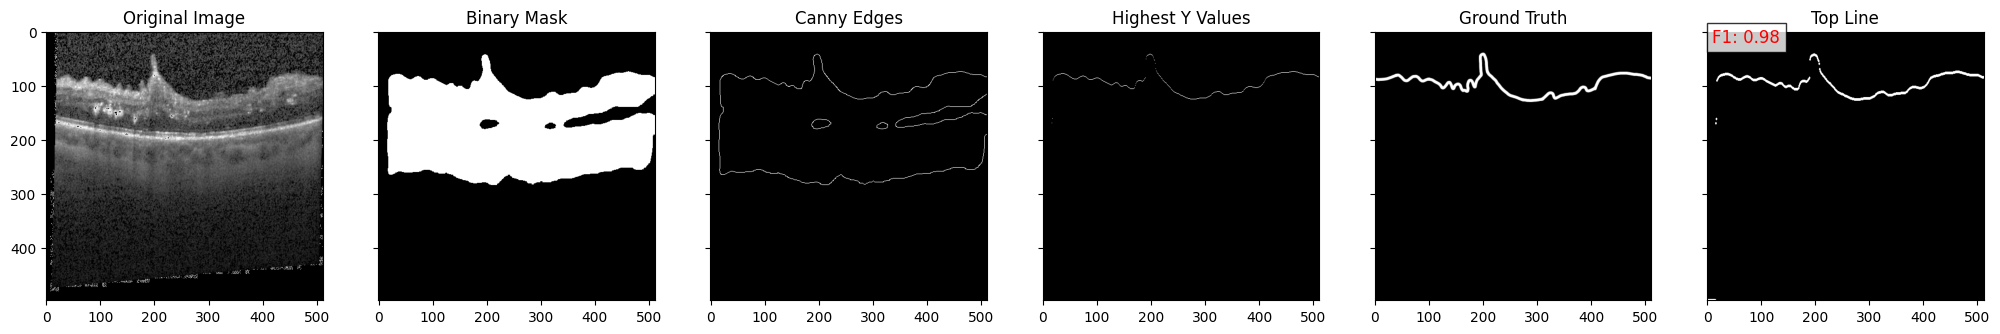

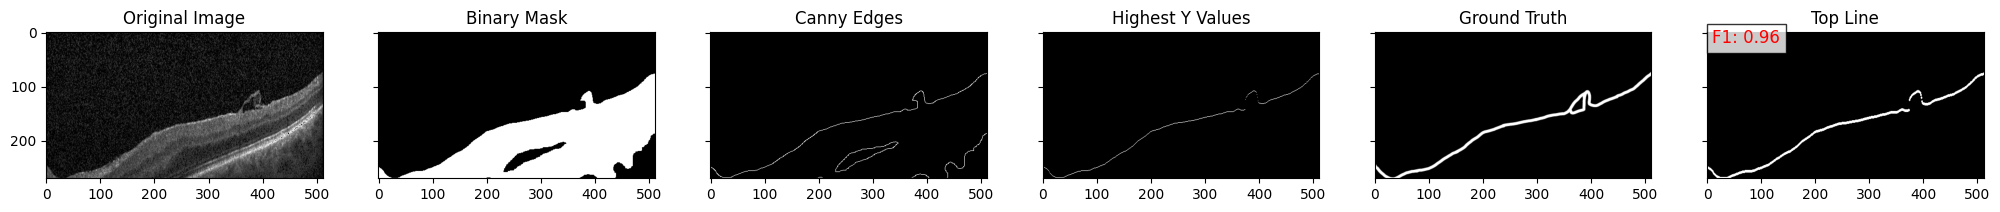

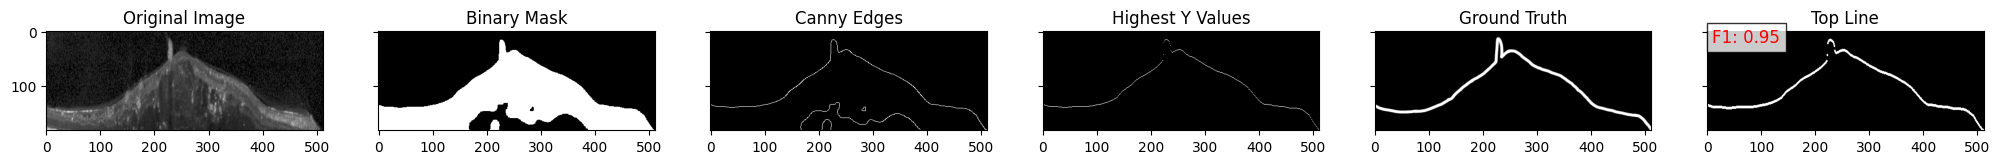

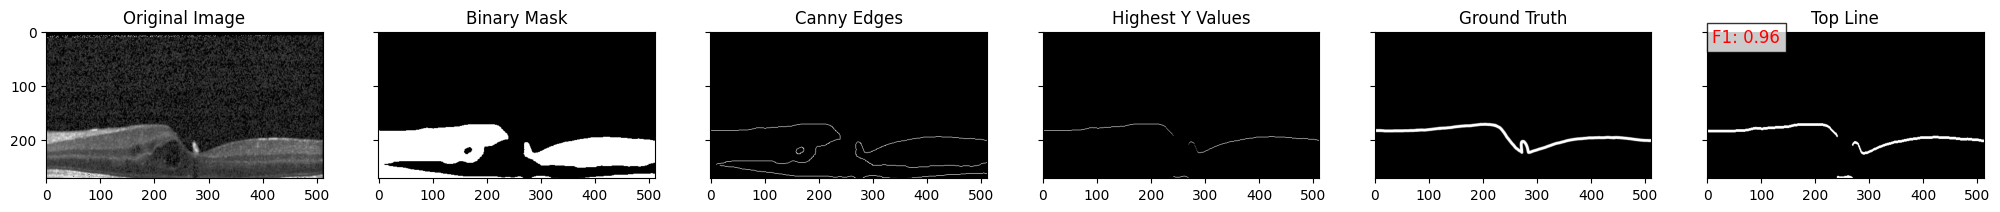

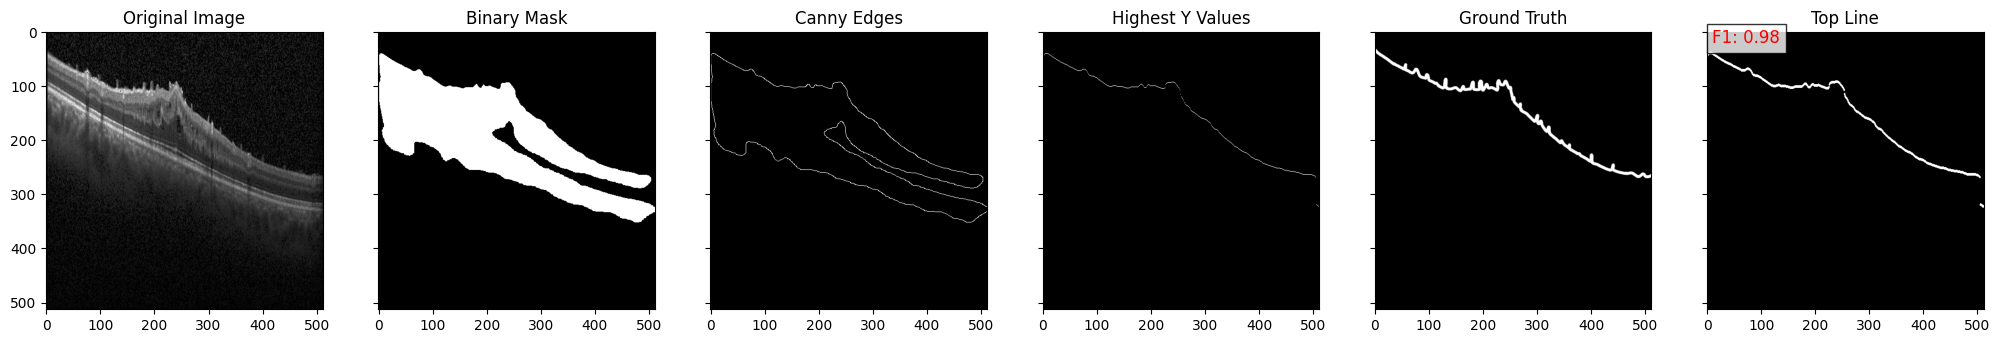

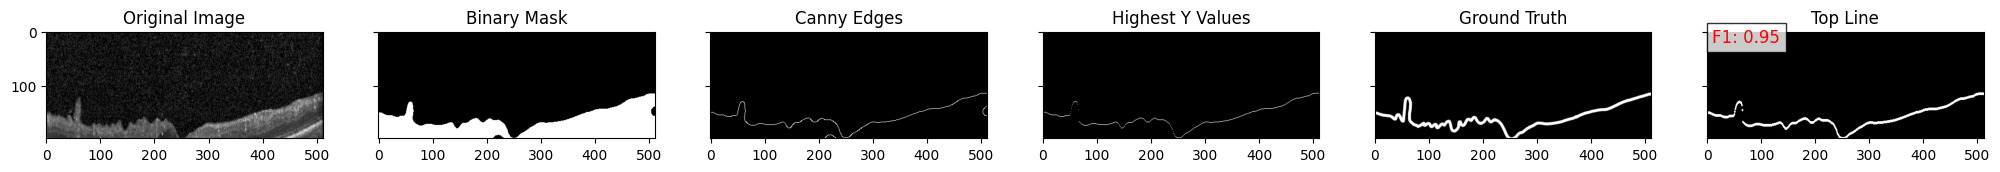

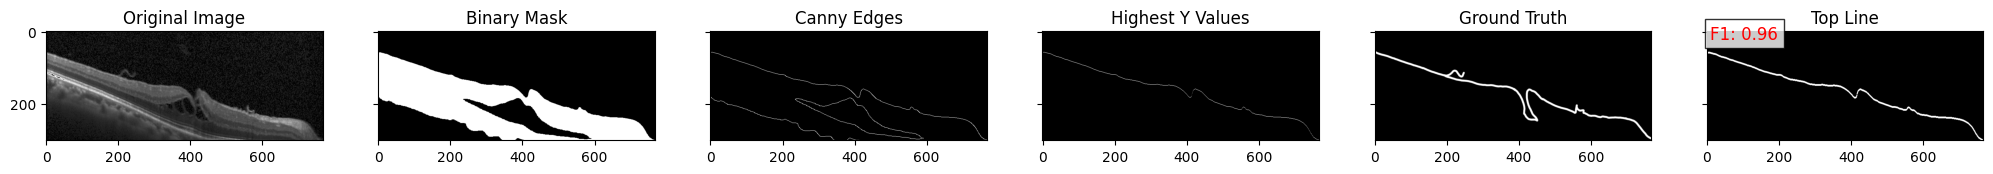

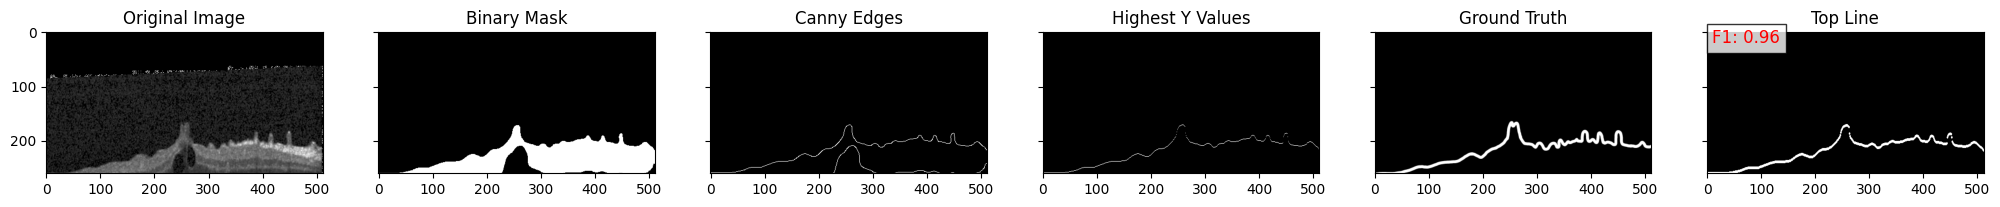

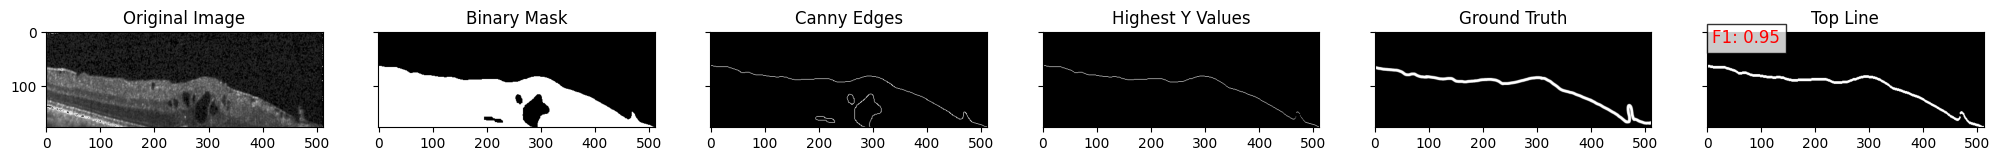

Average F1 Score: 0.96


In [29]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pywt
from sklearn.metrics import f1_score

def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise FileNotFoundError(f"Image at path {image_path} not found.")

    # Replace all white pixels (value > 250) with black
    image[image > 250] = 0

    # Detect and remove white borders
    _, thresh = cv2.threshold(image, 240, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Find all non-white pixels and get their coordinates
    non_white_pixels = np.where(thresh < 240)

    if non_white_pixels[0].size == 0 or non_white_pixels[1].size == 0:
        raise ValueError("No relevant pixels found in the image.")

    # Get the smallest and largest x and y coordinates and use them to create the bounding box
    y_min, y_max = np.min(non_white_pixels[0]), np.max(non_white_pixels[0])
    x_min, x_max = np.min(non_white_pixels[1]), np.max(non_white_pixels[1])

    # Crop the image to the bounding box of all non-white pixels
    image = image[y_min:y_max+1, x_min:x_max+1]

    # Noise reduction using median blur, bilateral filter, and non-local means denoising
    image_median = cv2.medianBlur(image, 5)
    image_bilateral = cv2.bilateralFilter(image_median, 9, 75, 75)
    image_denoised = cv2.fastNlMeansDenoising(image_bilateral, h=30)

    # Wavelet denoising
    coeffs = pywt.wavedec2(image_denoised, 'db1', level=2)
    coeffs[1:] = [tuple(pywt.threshold(i, value=10, mode='soft') for i in level) for level in coeffs[1:]]
    image_wavelet_denoised = pywt.waverec2(coeffs, 'db1')

    # Normalize and expand dimensions
    image_wavelet_denoised = np.expand_dims(image_wavelet_denoised, axis=-1)
    image_wavelet_denoised = np.expand_dims(image_wavelet_denoised, axis=0)
    image_wavelet_denoised = image_wavelet_denoised.astype('float32') / 255.0

    return image, image_wavelet_denoised

def binary_mask(image):
    # Convert the processed image to uint8
    image_uint8 = (image * 255).astype(np.uint8).squeeze()

    # Apply Gaussian blur
    blurred_image = cv2.GaussianBlur(image_uint8, (5, 5), 0)

    # Apply binary thresholding with Otsu's method
    _, binary_image = cv2.threshold(blurred_image, 62.5, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binary_image

def canny_edge_detection(image):
    edges = cv2.Canny(image, 100, 200)
    return edges

def extract_highest_y(edges):
    height, width = edges.shape
    highest_y_values = np.full(width, height)  # Initialize with maximum Y values (bottom of image)

    for x in range(width):
        column = edges[:, x]
        y_indices = np.where(column > 0)[0]
        if y_indices.size > 0:
            highest_y = y_indices.min()  # Get the highest (minimum) Y value
            highest_y_values[x] = highest_y  # Store the highest Y value

    return highest_y_values

def plot_highest_y_on_edges(edges, highest_y_values):
    height, width = edges.shape
    output_image = np.zeros_like(edges)

    for x, y in enumerate(highest_y_values):
        if y < height:  # Ensure we don't plot outside the image
            output_image[y, x] = 255  # Plot highest Y values in white

    return output_image

def extract_top_line(highest_y_values):
    # Create an image with the top line plotted
    height = np.max(highest_y_values) + 1  # Ensure the image height is sufficient
    width = len(highest_y_values)
    top_line_image = np.zeros((height, width), dtype=np.uint8)

    # Draw the top line, making it bold
    for x, y in enumerate(highest_y_values):
        if y < height:  # Ensure we don't plot outside the image
            cv2.line(top_line_image, (x, y), (x, y + 2), 255, 2)  # Plot bold line in white

    return top_line_image

def concatenate_paths(base_path, filenames):
    return [os.path.join(base_path, filename) for filename in filenames]

def calculate_f1_score(ground_truth_image, predicted_image):
    # Flatten the images to 1D arrays
    ground_truth_flat = ground_truth_image.flatten()
    predicted_flat = predicted_image.flatten()

    # Calculate the F1 score
    f1 = f1_score(ground_truth_flat, predicted_flat, average='micro')
    return f1

def process_and_visualize_images(test_image_paths, eval_image_paths):
    f1_scores = []

    for test_image_path, eval_image_path in zip(test_image_paths, eval_image_paths):
        # Preprocess the image
        original_image, preprocessed_image = preprocess_image(test_image_path)

        # Apply binary masking
        binary_image = binary_mask(preprocessed_image)

        # Apply Canny edge detection
        edges = canny_edge_detection(binary_image)

        # Extract highest Y value edges
        highest_y_values = extract_highest_y(edges)

        # Plot highest Y values on the edges image
        highest_y_image = plot_highest_y_on_edges(edges, highest_y_values)

        # Extract and plot only the top line
        top_line_image = extract_top_line(highest_y_values)

        # Load ground truth image
        ground_truth_image = cv2.imread(eval_image_path, cv2.IMREAD_GRAYSCALE)
        if ground_truth_image is None:
            raise FileNotFoundError(f"Ground truth image at path {eval_image_path} not found.")

        # Resize The Picture incase of mismatch

        if ground_truth_image.shape != top_line_image.shape:
            # Resize predicted_image to match ground_truth_image
            predicted_image = cv2.resize(top_line_image, (ground_truth_image.shape[1], ground_truth_image.shape[0]))
        else: 
            predicted_image = top_line_image

        # Flatten the images
        ground_truth_flat = ground_truth_image.flatten()
        predicted_flat = predicted_image.flatten()
        
        # Calculate F1 score
        f1 = calculate_f1_score(ground_truth_flat, predicted_flat)
        f1_scores.append(f1)

        # Visualize the results
        fig, axs = plt.subplots(1, 6, figsize=(25, 5), sharey=True)
        
        axs[0].imshow(original_image, cmap='gray')
        axs[0].set_title('Original Image')

        axs[1].imshow(binary_image, cmap='gray')
        axs[1].set_title('Binary Mask')

        axs[2].imshow(edges, cmap='gray')
        axs[2].set_title('Canny Edges')

        axs[3].imshow(highest_y_image, cmap='gray')
        axs[3].set_title('Highest Y Values')

        axs[4].imshow(ground_truth_image, cmap='gray')
        axs[4].set_title('Ground Truth')

        axs[5].imshow(top_line_image, cmap='gray')
        axs[5].set_title('Top Line')
        axs[5].text(10, 20, f'F1: {f1:.2f}', color='red', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

        plt.show()

    # Print the average F1 score
    print(f"Average F1 Score: {np.mean(f1_scores):.2f}")

# Example usage
test_base_path = 'DATA_OCT'
eval_base_path = 'BOOM_ILM'

# Lists of filenames for test and evaluation datasets
test_filenames = [
    'dr_test_1190_NV.jpg', 'img_02.jpeg', 'img_04.jpeg',
    'img_05.jpeg', 'img_06.jpeg', 'img_07.jpeg',
    'img_08.jpeg', 'img_09.jpeg', 'img_10.jpeg',
    'img_11.jpeg', 'img_15.jpeg', 'img_16.jpeg',
    'img_17.jpeg', 'img_18.jpeg', 'img_19.jpeg',
    'img_21.jpeg', 'img_23.jpeg', 'img_24.jpeg',
    'img_25.jpeg'
]

eval_filenames = [
    'dr_test_1190_NV_ILM.png', 'img_02_ILM.png', 'img_04_ILM.png',
    'img_05_ILM.png', 'img_06_ILM.png', 'img_07_ILM.png',
    'img_08_ILM.png', 'img_09_ILM.png', 'img_10_ILM.png',
    'img_11_ILM.png', 'img_15_ILM.png', 'img_16_ILM.png',
    'img_17_ILM.png', 'img_18_ILM.png', 'img_19_ILM.png',
    'img_21_ILM.png', 'img_23_ILM.png', 'img_24_ILM.png',
    'img_25_ILM.png'
]

test_image_paths = concatenate_paths(test_base_path, test_filenames)
eval_image_paths = concatenate_paths(eval_base_path, eval_filenames)

# Combine and process both test and evaluation image paths
process_and_visualize_images(test_image_paths, eval_image_paths)
